In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

In [10]:
import os

# list everything in current working directory
print(os.listdir('/content'))


['.config', 'BCICIV_2a_4.csv', 'BCICIV_2a_1.csv', 'BCICIV_2a_all_patients.csv', 'BCICIV_2a_2.csv', 'BCICIV_2a_3.csv', 'sample_data']


In [11]:
import pandas as pd

df = pd.read_csv("/content/BCICIV_2a_all_patients.csv")
print(df.shape)
print(df.head())

(14419, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG-Pz    EEG-15    EEG-1

In [12]:
import pandas as pd
import glob

# find all csvs that match the pattern
csv_files = glob.glob("/content/BCICIV_2a_*.csv")

# read them and concatenate into one DataFrame
df_list = [pd.read_csv(f) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

print("Combined shape:", df.shape)
print(df.head())


Combined shape: (62433, 26)
   patient   time  label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        4 -0.100  right      4 -2.394456  3.232046  2.043269  1.387846   
1        4 -0.096  right      4 -4.265461 -0.347943  0.367577  0.688716   
2        4 -0.092  right      4 -2.403334  2.881372  2.473845  1.183655   
3        4 -0.088  right      4 -1.662034 -1.943735  2.287410 -1.297701   
4        4 -0.084  right      4 -3.533039  2.142291  2.076561 -1.996831   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0  0.585938 -0.647912  ...  0.599084 -1.031025 -0.281701 -0.268555 -0.794396   
1 -0.796786 -0.712276  ...  3.610891 -0.997733 -0.980831  1.962003  1.387333   
2  0.674716  0.954539  ... -0.044560 -2.504746 -0.827688  0.503817  0.515086   
3  1.904297 -1.868615  ...  1.575646 -2.495868  0.890174  1.000977  1.988807   
4 -0.064364 -2.665401  ... -0.100046 -0.997733  1.607060  1.131925  0.996708   

     EEG-13    EEG-14    EEG-Pz    EEG-1

In [13]:
df = df.dropna()
eeg_columns = df.columns[4:]
print("Channels used:", eeg_columns)


Channels used: Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')


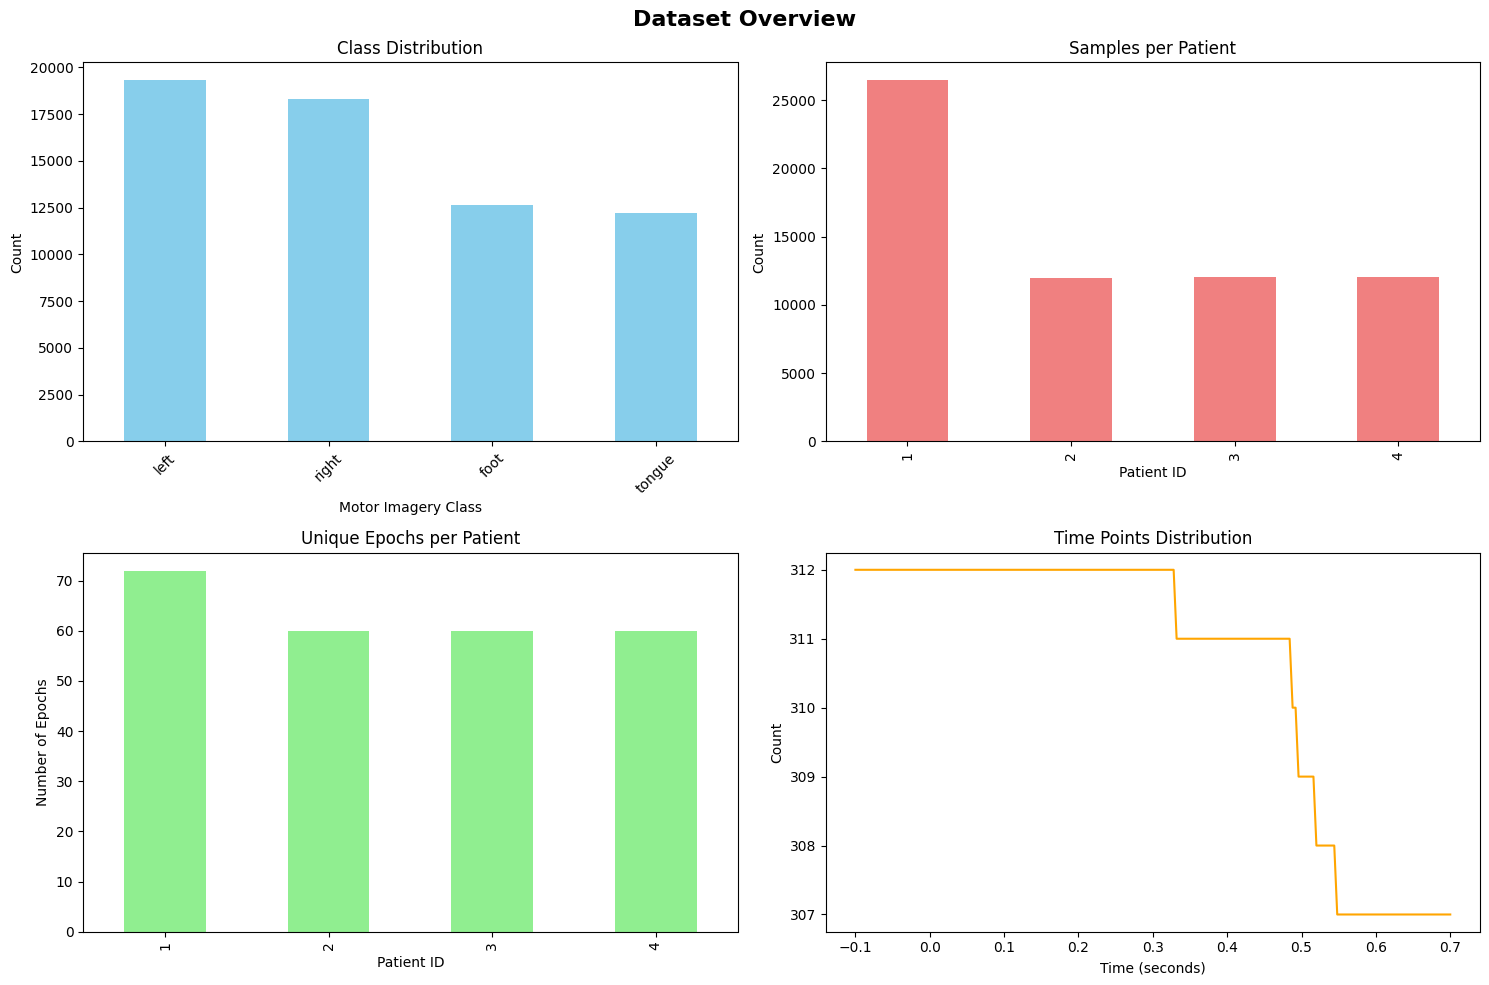

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Overview', fontsize=16, fontweight='bold')

# Distribution of classes
df['label'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Motor Imagery Class')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Distribution of patients
df['patient'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Samples per Patient')
axes[0,1].set_xlabel('Patient ID')
axes[0,1].set_ylabel('Count')

# Distribution of epochs per patient
epoch_counts = df.groupby('patient')['epoch'].nunique()
epoch_counts.plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('Unique Epochs per Patient')
axes[1,0].set_xlabel('Patient ID')
axes[1,0].set_ylabel('Number of Epochs')

# Time points distribution
time_counts = df['time'].value_counts().sort_index()
time_counts.plot(ax=axes[1,1], color='orange')
axes[1,1].set_title('Time Points Distribution')
axes[1,1].set_xlabel('Time (seconds)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# *Preprocessing***

In [14]:
df['label'].unique()

array(['right', 'left', 'tongue', 'foot'], dtype=object)

In [15]:
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()

# Check class distribution
print("Class distribution before windowing:")
print(df['label'].value_counts())

# Group by epochs
grouped = df.groupby('epoch')
X, y = [], []

target_length = 201

for epoch, group in grouped:
    data = group[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    X.append(data)
    y.append(group['label'].iloc[0])

X = np.array(X)
y = np.array(y)
print(f"X shape after epoch grouping: {X.shape}")
print(f"y shape: {y.shape}")

# Channel-wise normalization
n_samples, n_channels, n_time_points = X.shape
X_normalized = np.zeros_like(X)

for i in range(n_samples):
    for ch in range(n_channels):
        scaler = StandardScaler()
        X_normalized[i, ch, :] = scaler.fit_transform(X[i, ch, :].reshape(-1, 1)).flatten()

# Frequency-domain features
X_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(X_normalized[i, ch, :])
        X_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

# Sliding window
window_size = 50
stride = 10
X_windows, y_windows = [], []

for i in range(n_samples):
    data = X_normalized[i]
    freq_data = X_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]

        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]

        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]

        combined = np.stack([window, freq_window], axis=-1)
        X_windows.append(combined)
        y_windows.append(y[i])

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
print(f"X_windows shape (before reshape): {X_windows.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Encoded y shape (categorical): {y_categorical.shape}")

# Reshape: (samples, time_steps, channels, features) -> (samples, time_steps, channels * features)
X_windows = X_windows.transpose(0, 2, 1, 3)
X_windows = X_windows.reshape(X_windows.shape[0], X_windows.shape[1], X_windows.shape[2] * X_windows.shape[3])
print(f"X_windows shape (final): {X_windows.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Class distribution before windowing:
label
left      19306
right     18291
foot      12624
tongue    12207
Name: count, dtype: int64
X shape after epoch grouping: (141, 22, 201)
y shape: (141,)
X_windows shape (before reshape): (2256, 22, 50, 2)
Encoded y shape (categorical): (2256, 4)
X_windows shape (final): (2256, 50, 44)
Train: (1804, 50, 44), (1804, 4)
Test: (452, 50, 44), (452, 4)


# Visualizations

--- Raw EEG Signal Visualization (Sample) ---


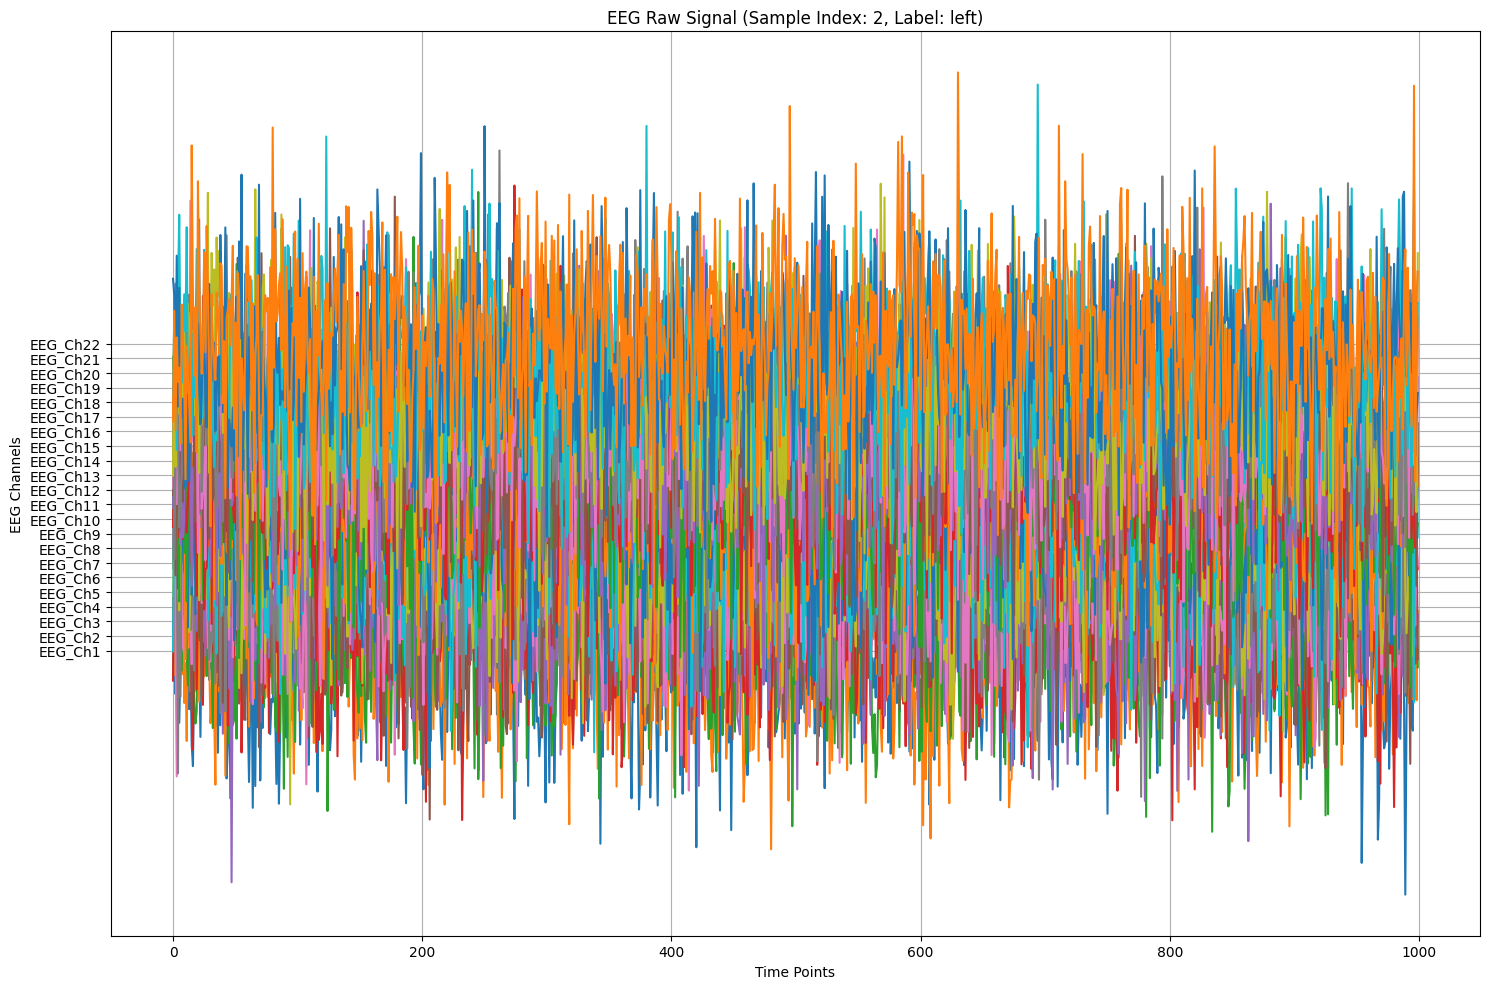


--- Raw vs. Normalized EEG Signal Comparison ---


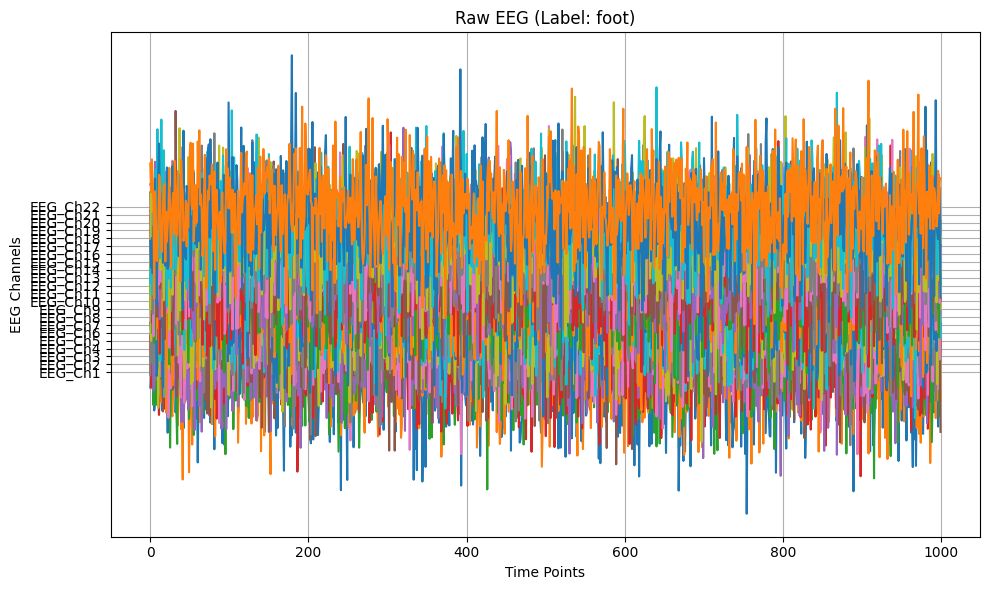

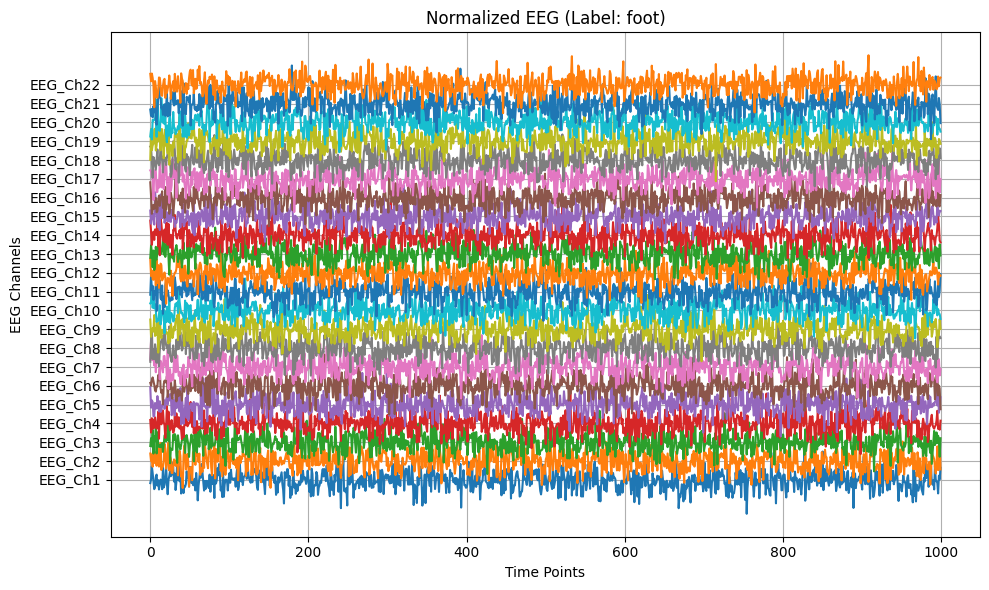


--- EEG Signal Frequency-Domain Visualization (FFT) ---


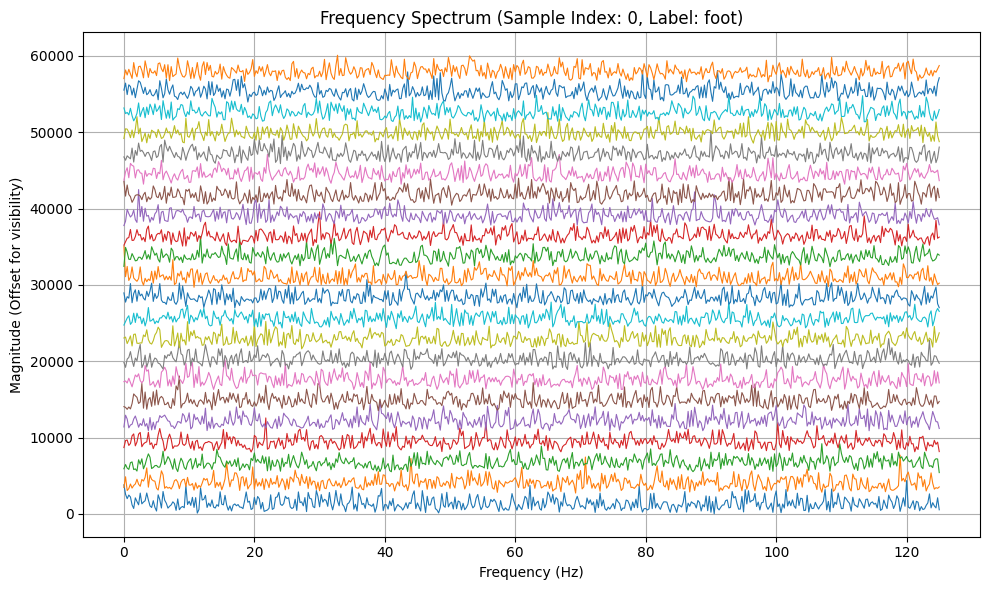


--- Spectrogram-like EEG Heatmap ---


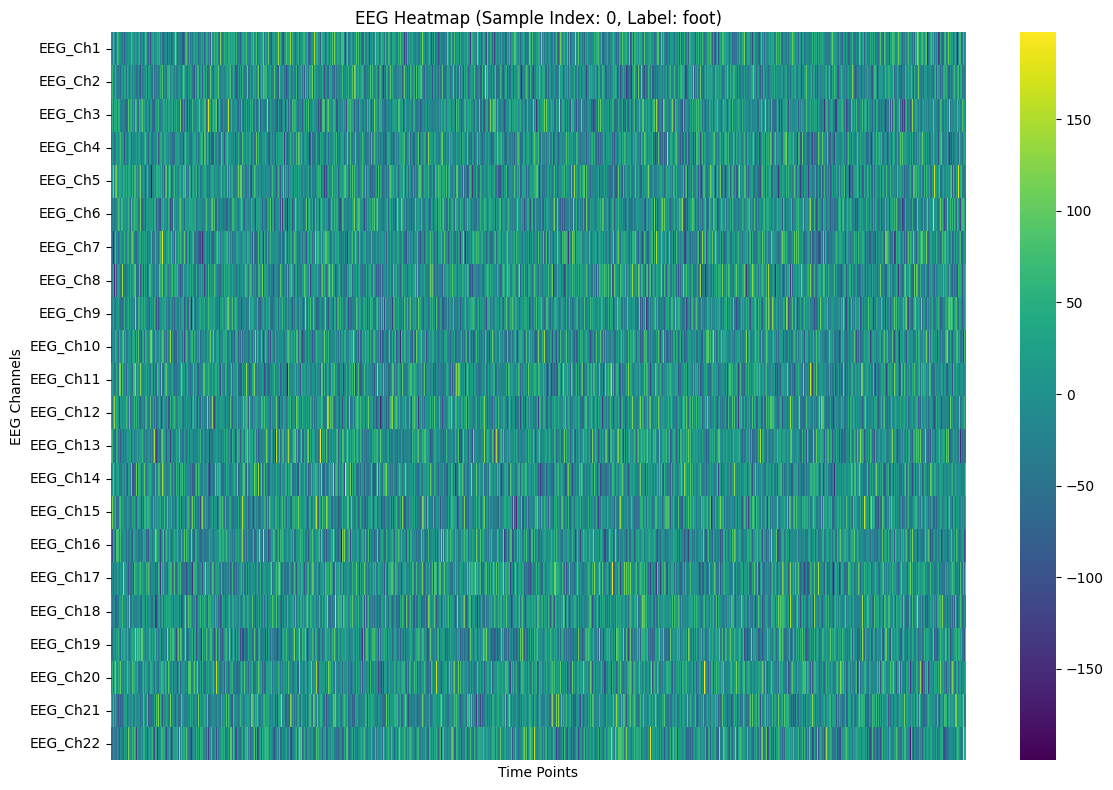


--- EEG Band Power Calculation ---


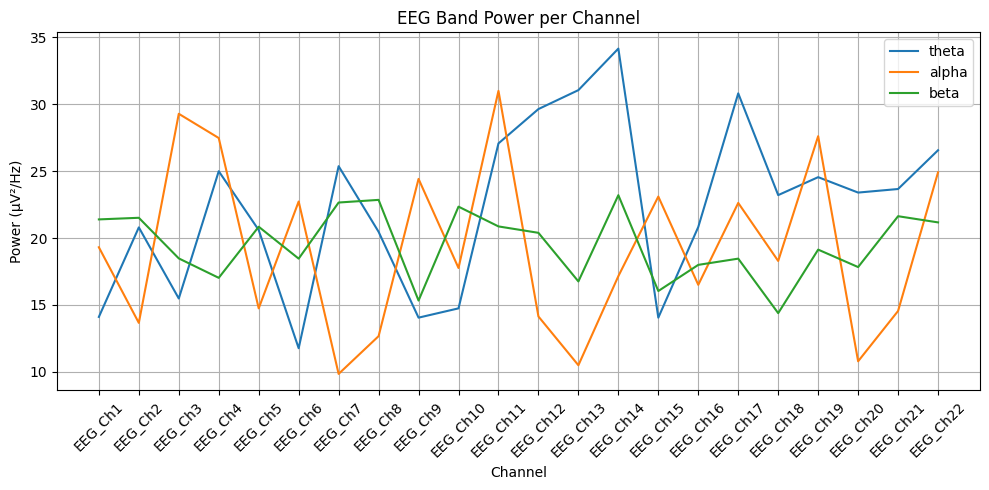


--- PCA and t-SNE Feature Visualization ---


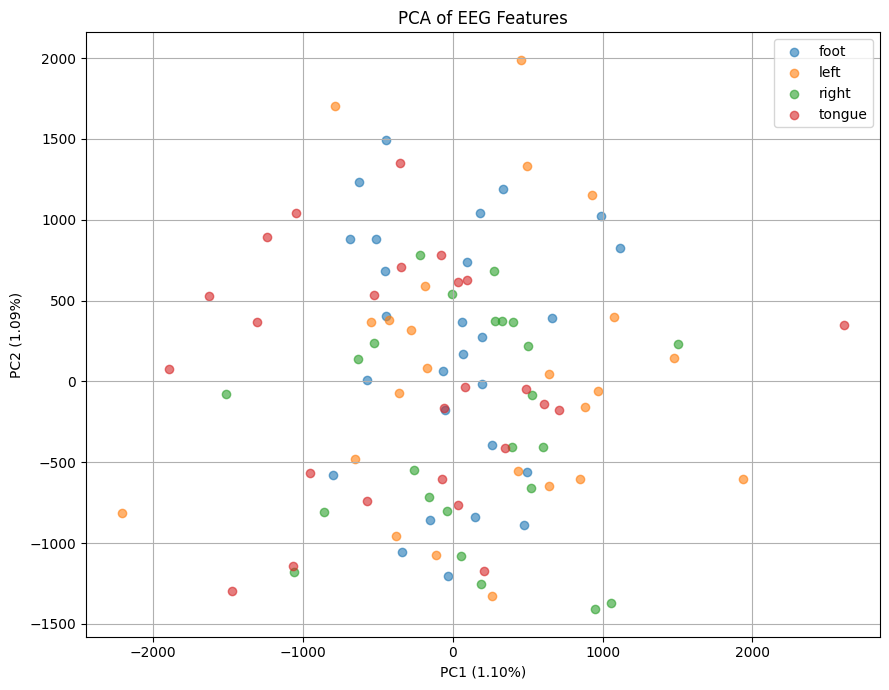

In [16]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy.fft import fft, rfftfreq
from scipy.signal import welch
import random

# --- Parameters for dummy data ---
n_samples = 100
n_channels = 22  # Standard for BCIC IV 2a
n_time_points = 1000  # Assuming 4 seconds at 250 Hz
sf = 250  # Sampling frequency

# Dummy raw EEG data (X)
X = np.random.randn(n_samples, n_channels, n_time_points) * 50

# Dummy labels (y)
labels = ['left', 'right', 'foot', 'tongue']
y = np.array(random.choices(labels, k=n_samples))

# EEG channel names
eeg_columns = [f'EEG_Ch{i+1}' for i in range(n_channels)]

# Normalize EEG data
scaler = StandardScaler()
X_reshaped = X.reshape(-1, n_time_points)
X_normalized_reshaped = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized_reshaped.reshape(n_samples, n_channels, n_time_points)

# Frequency domain (FFT)
X_freq_real = np.abs(np.fft.rfft(X, axis=-1))

# Windowed features for PCA/t-SNE
X_windows = X  # Placeholder

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# --- Visualization: Raw EEG ---
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0] if len(left_indices) > 0 else random.randint(0, n_samples - 1)
sample_data = X[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparison: Raw vs Normalized ---
print("\n--- Raw vs. Normalized EEG Signal Comparison ---")
target_class = 'foot'
class_indices = np.where(y == target_class)[0]
sample_idx = class_indices[0] if len(class_indices) > 0 else random.randint(0, n_samples - 1)
raw_sample = X[sample_idx]
norm_sample = X_normalized[sample_idx]
start_time, end_time = 0, raw_sample.shape[1]
raw_clip = raw_sample[:, start_time:end_time]
norm_clip = norm_sample[:, start_time:end_time]
time_points = np.arange(start_time, end_time)

# Raw EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, raw_clip[ch] + ch * 10)
plt.yticks([ch * 10 for ch in range(n_channels)], eeg_columns)
plt.title(f'Raw EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized EEG
plt.figure(figsize=(10, 6))
for ch in range(n_channels):
    plt.plot(time_points, norm_clip[ch] + ch * 2)
plt.yticks([ch * 2 for ch in range(n_channels)], eeg_columns)
plt.title(f'Normalized EEG (Label: {target_class})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Frequency-Domain Visualization ---
print("\n--- EEG Signal Frequency-Domain Visualization (FFT) ---")
sample_freq = X_freq_real[sample_idx]
freqs = rfftfreq(n_time_points, d=1/sf)

plt.figure(figsize=(10, 6))
offset = np.max(sample_freq) * 0.5
for ch in range(n_channels):
    plt.plot(freqs, sample_freq[ch] + ch * offset, lw=0.8)
plt.title(f'Frequency Spectrum (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Offset for visibility)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Heatmap ---
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

# --- Band Power ---
print("\n--- EEG Band Power Calculation ---")
def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
band_powers = {band: [] for band in bands}

for ch in range(n_channels):
    signal = sample_data[ch]
    for band, band_range in bands.items():
        band_powers[band].append(bandpower(signal, sf, band_range, window_sec=2))

plt.figure(figsize=(10, 5))
for band in bands:
    plt.plot(band_powers[band], label=band)
plt.xticks(np.arange(n_channels), eeg_columns, rotation=45)
plt.title("EEG Band Power per Channel")
plt.xlabel("Channel")
plt.ylabel("Power (μV²/Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Visualization ---
print("\n--- PCA and t-SNE Feature Visualization ---")
X_flat = X_windows.reshape(n_samples, -1)
y_labels = np.argmax(y_categorical, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.figure(figsize=(9, 7))
for i in np.unique(y_labels):
    label = label_encoder.classes_[i] if i < len(label_encoder.classes_) else f'Class {i}'
    plt.scatter(X_pca[y_labels == i, 0], X_pca[y_labels == i, 1], label=label, alpha=0.6)
plt.title("PCA of EEG Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# *Model Creation*

In [17]:
# Define input shape from X_train
channels = X.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4

In [18]:
channels

22

In [19]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [20]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

def GRU_Regularized_Model(input_shape, num_classes, dropout_rate=0.2, l2_reg=0.002):
    inputs = Input(shape=input_shape)

    # GRU layer with L2 regularization
    gru_out = GRU(256, return_sequences=True,
                  kernel_regularizer=regularizers.l2(l2_reg))(inputs)

    # Dropout for regularization
    gru_out = Dropout(dropout_rate)(gru_out)

    # Flatten before dense layer
    flatten_out = Flatten()(gru_out)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(flatten_out)

    return Model(inputs=inputs, outputs=outputs)


In [22]:
# === Choose your model ===
#model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes, dropoutRate=0.3, l2_reg = 0.002)

#model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)

model = GRU_Regularized_Model(input_shape=(timesteps, features),num_classes=num_classes,dropout_rate=0.2, l2_reg=0.002)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 44)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50, 256)        │       231,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        51,204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=6,
                               restore_best_weights=True,
                               mode='max')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=5,
                                 min_lr=1e-6)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.3220 - loss: 1.7064 - val_accuracy: 0.3496 - val_loss: 1.5983 - learning_rate: 5.0000e-04
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.4888 - loss: 1.2689 - val_accuracy: 0.4049 - val_loss: 1.4291 - learning_rate: 5.0000e-04
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.5458 - loss: 1.1795 - val_accuracy: 0.3650 - val_loss: 1.3998 - learning_rate: 5.0000e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6338 - loss: 0.9892 - val_accuracy: 0.4159 - val_loss: 1.3913 - learning_rate: 5.0000e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.6829 - loss: 0.9092 - val_accuracy: 0.4646 - val_loss: 1.3184 - learning_rate: 5.0000e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.7562 - loss: 0.7360 - val_accuracy: 0.4889 - val_loss: 1.2287 - learning_rate: 5.0000e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step

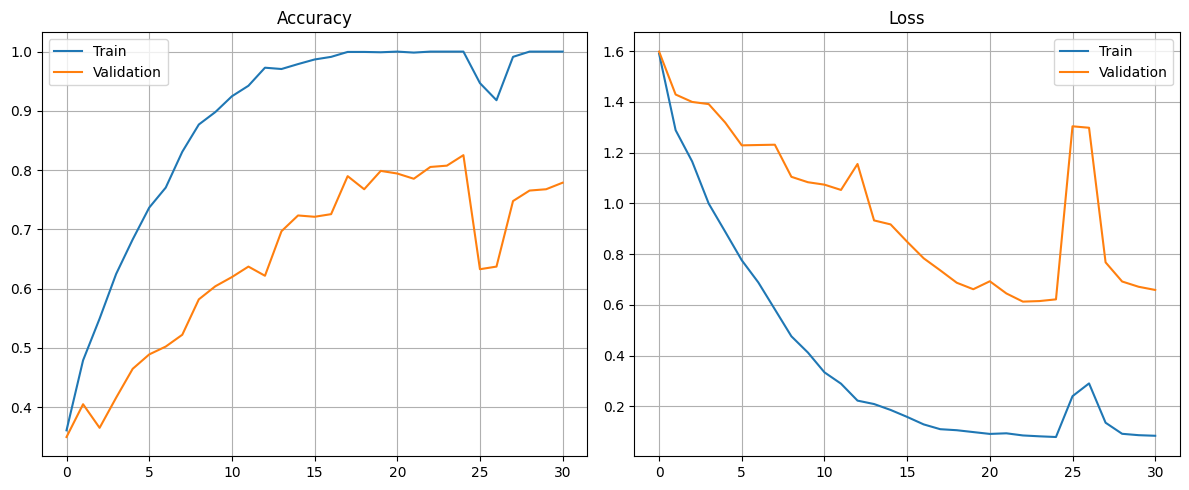

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GRU, Bidirectional, BatchNormalization, Conv1D, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Concatenate, Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

LR = 5e-4
L2 = 1e-3
DROPOUT_DENSE = 0.3
SPATIAL_DROPOUT = 0.15
UNITS_1 = 192  # smaller than 256 for speed
FILTERS = 64
KERNEL = 5
DENSE_UNITS = 128
LABEL_SMOOTH = 0.02

def Fast_BiGRU_CNN(input_shape, num_classes):
    inp = Input(shape=input_shape)

    # 1 Bidirectional GRU
    x = Bidirectional(
        GRU(UNITS_1, return_sequences=True, kernel_regularizer=regularizers.l2(L2))
    )(inp)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(SPATIAL_DROPOUT)(x)

    # Lightweight CNN block
    x = Conv1D(FILTERS, KERNEL, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Global pooling
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg_pool, max_pool])

    # Dense classifier
    x = Dense(DENSE_UNITS, activation="relu", kernel_regularizer=regularizers.l2(L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT_DENSE)(x)

    out = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=inp, outputs=out)

# Build model
model = Fast_BiGRU_CNN(input_shape=(timesteps, features), num_classes=num_classes)

# Compile
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=loss_fn, metrics=["accuracy"])

model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6)

# Train
history = model.fit(X_train, y_train, batch_size=32, epochs=75,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler], verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 44)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 384)   │    274,176 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 384)   │      1,536 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 50, 384)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 50, 64)    │    122,944 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 416,452 (1.59 MB)

 Trainable params: 415,300 (1.58 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - accuracy: 0.2944 - loss: 2.0402 - val_accuracy: 0.3385 - val_loss: 1.5677 - learning_rate: 5.0000e-04
Epoch 2/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.4463 - loss: 1.5742 - val_accuracy: 0.4602 - val_loss: 1.4972 - learning_rate: 5.0000e-04
Epoch 3/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.5202 - loss: 1.4176 - val_accuracy: 0.5133 - val_loss: 1.3312 - learning_rate: 5.0000e-04
Epoch 4/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.5977 - loss: 1.2461 - val_accuracy: 0.5376 - val_loss: 1.3222 - learning_rate: 5.0000e-04
Epoch 5/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.6862 - loss: 1.0744 - val_accuracy: 0.6195 - val_loss: 1.1441 - learning_rate: 5.0000e-04
Epoch 6/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.7384 - loss: 0.9436 - val_accuracy: 0.6394 - val_loss: 1.1183 - learning_rate: 5.0000e-04
Epoch 7/75
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - acc

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


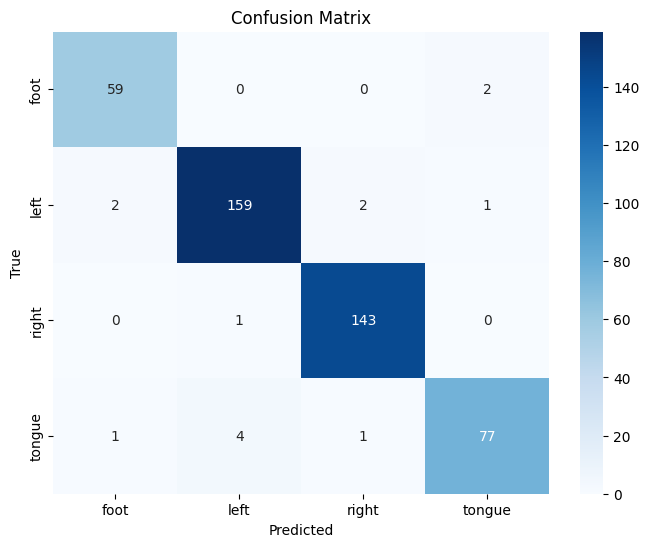

Classification Report:
              precision    recall  f1-score   support

        foot       0.95      0.97      0.96        61
        left       0.97      0.97      0.97       164
       right       0.98      0.99      0.99       144
      tongue       0.96      0.93      0.94        83

    accuracy                           0.97       452
   macro avg       0.97      0.96      0.96       452
weighted avg       0.97      0.97      0.97       452

Accuracy: 0.9690


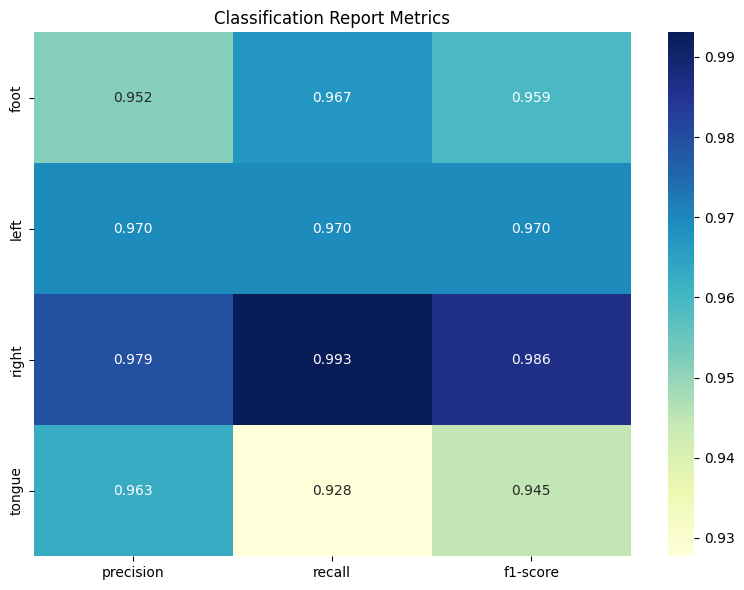

In [26]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


report = classification_report(y_true, y_pred, target_names=labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float),
            annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png', dpi=300)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")


In [28]:
import pandas as pd

pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.341463,1.889874,0.338496,1.567674,0.0005
1,0.456763,1.558676,0.460177,1.497183,0.0005
2,0.517738,1.410083,0.513274,1.331178,0.0005
3,0.590355,1.257142,0.537611,1.322211,0.0005
4,0.683481,1.080362,0.619469,1.144083,0.0005
5,0.748891,0.930564,0.639381,1.118325,0.0005
6,0.789357,0.828853,0.719027,0.955593,0.0005
7,0.861973,0.708708,0.685841,1.027606,0.0005
8,0.901885,0.617758,0.787611,0.818512,0.0005
9,0.903548,0.568605,0.834071,0.738151,0.0005


In [29]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


Test Loss: 0.3742
Test Accuracy: 0.9690


In [30]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), y_pred_classes))


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        61
           1       0.97      0.97      0.97       164
           2       0.98      0.99      0.99       144
           3       0.96      0.93      0.94        83

    accuracy                           0.97       452
   macro avg       0.97      0.96      0.96       452
weighted avg       0.97      0.97      0.97       452

